In [2]:
%load_ext autoreload
%autoreload 2
import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [3]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    6907,
    # 63,
    [
                Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-6907-3.npz", 
        # Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/spice-esp-dip-63-0.npz"
        # Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-40000-0.npz"#"data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True,
    natoms=60,
    esp_mask=True,
)


n_failed: 286
0 6621
shape (6907, 60, 3)
D (6621,)
R (6621, 60, 3)
(6621,)
['id', 'R', 'Z', 'N', 'mono', 'esp', 'vdw_surface', 'n_grid', 'D', 'Dxyz', 'com', 'espMask']
6621
0 id 6621 (6621,)
1 R 6621 (6621, 60, 3)
2 Z 6621 (6621, 60)
3 N 6621 (6621, 1)
4 mono 6621 (6621, 60)
5 esp 6621 (6621, 3200)
6 vdw_surface 6621 (6621, 3200, 3)
7 n_grid 6621 (6621,)
8 D 6621 (6621, 1)
9 Dxyz 6621 (6621, 3)
10 com 6621 (6621, 3)
11 espMask 6621 (6621, 3200)


In [22]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

sparse_pairwise_indices
3540


In [23]:
len(valid_data["R"]), len(valid_batches)

(6621, 6621)

In [24]:
valid_data.keys()

dict_keys(['id', 'R', 'Z', 'N', 'mono', 'esp', 'vdw_surface', 'n_grid', 'D', 'Dxyz', 'com', 'espMask'])

In [25]:
valid_batches[0].keys()

dict_keys(['R', 'Z', 'N', 'mono', 'esp', 'vdw_surface', 'n_grid', 'D', 'Dxyz', 'com', 'espMask', 'dst_idx', 'src_idx', 'batch_segments'])

In [26]:
valid_data["R"].shape

(6621, 60, 3)

In [45]:
N = len(valid_data["Z"])
N = 1000
random_ids = [random.randint(0, len(valid_batches)) for _ in range(N)]
# random_ids = [_ for _ in range(len(valid_data["Z"]))]

In [46]:
# for _ in list((ddir / "vdwr14").glob("*/best*pkl")):
#     print("restart="+str(_))
#     print("sbatch --export=restart=$restart restart.sh")
#     print()

In [47]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")

In [48]:
# list(ddir.glob("test4/*/best*"))

In [58]:
# files = {_.parents[0].name: _ for _ in list(ddir.glob("test3/*1002*/best*"))}
# files = {_.parents[0].name: _ for _ in list(ddir.glob("test4/*/best*"))}
# files = {_.parents[0].name: _ for _ in list(ddir.glob("spice1/*/best*"))}
# files = {_.parents[0].name: _ for _ in list(ddir.glob("dcr175/*/best*"))}
# files = {_.parents[0].name: _ for _ in list(ddir.glob("dipo/*/best*"))}
files = {_.parents[0].name: _ for _ in list(ddir.glob("diponore/*/best*"))}
KEYS = list(files.keys())
for i, _ in enumerate(KEYS):
    print(i, _)
    # print("sbatch --export=restart={} jobsRE.sh".format(files[_]))
    # print("sleep 3")
    # print("sbatch --mem-per-cpu=5000 --wrap \"JAX_PLATFORMS=cpu; python test_analysis_4.py --path {}\"".format(files[_]))

0 20241017-165214dcm-3-w-10000.0-re-True-ptTrue
1 20241017-165934dcm-2-w-10000.0-re-True-ptTrue
2 20241017-165958dcm-4-w-10000.0-re-True-ptTrue
3 20241017-170104dcm-4-w-10000.0-re-True-ptTrue
4 20241017-170124dcm-3-w-10000.0-re-True-ptTrue
5 20241017-172025dcm-2-w-10000.0-re-True-ptTrue


In [59]:
# 7 
# 10

p= files[KEYS[3]]
print(p)
model, params, _ = create_model_and_params(p)
# model
_

/pchem-data/meuwly/boittier/home/jaxeq/all_runs/diponore/20241017-170104dcm-4-w-10000.0-re-True-ptTrue/best_10000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 4.0, 'include_pseudotensors': False, 'debug': False}


{'features': 16.0,
 'max_degree': 2.0,
 'num_iterations': 2.0,
 'num_basis_functions': 16.0,
 'cutoff': 4.0,
 'max_atomic_number': 17.0,
 'n_dcm': 4.0,
 'include_pseudotensors': False,
 'data_dir': '/pchem-data/meuwly/boittier/home/jaxeq/',
 'model_dir': 'model',
 'num_epochs': 5000.0,
 'learning_rate': 0.001,
 'batch_size': 1.0,
 'esp_w': 10000.0,
 'num_epics': 1.0,
 'n_feat': 16.0,
 'n_basis': 16.0,
 'n_mp': 2.0,
 'restart': '/pchem-data/meuwly/boittier/home/jaxeq/all_runs/dipo/20241017-124554dcm-4-w-10000.0-re-True-ptTrue/best_10000.0_params.pkl',
 'random_seed': 28038.0,
 'n_gpu': 0.0,
 'data': '/pchem-data/meuwly/boittier/home/jaxeq/data/qm9-esp-dip-40000-0.npz_/pchem-data/meuwly/boittier/home/jaxeq/data/qm9-esp-dip-40000-1.npz_/pchem-data/meuwly/boittier/home/jaxeq/data/qm9-esp-dip-40000-2.npz',
 'n_train': 78575.0,
 'n_valid': 2000.0,
 'type': 'dipole'}

In [60]:
model

MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 4
    include_pseudotensors = True
)

In [61]:
max(random_ids),len(valid_batches)
# valid_batches[i]

(6617, 6621)

In [62]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(random_ids):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=False,
                                           id=False,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    # print(pred_D, D_test)
    derr.append( abs(pred_D - D_test))
    
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:26<00:00,  1.24it/s]


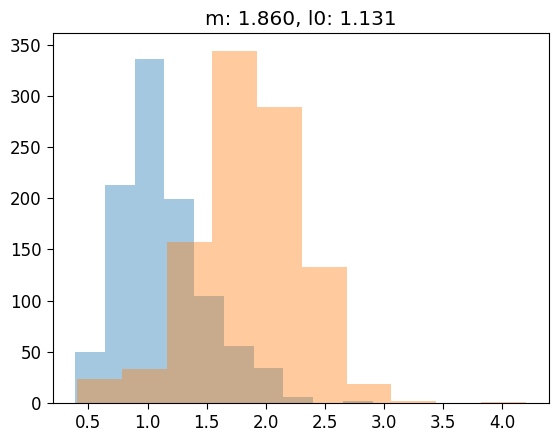

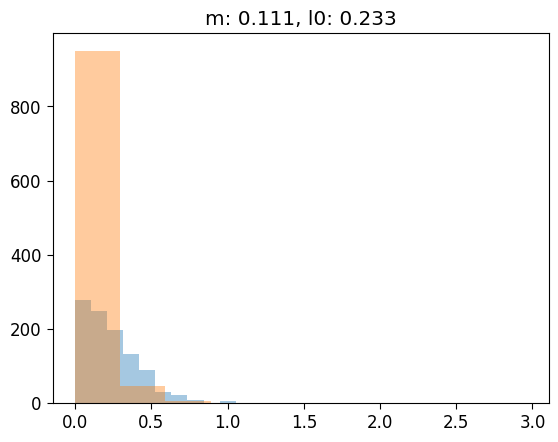

In [63]:
m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T[0]
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [64]:
a,b = np.array(dipole_errors).T[0]


In [65]:
import pandas as pd

df_ = pd.DataFrame({"i": indexes, "m": m.flatten(), "l0": l0.flatten(), "dm": dm, "dl0": dl0})


In [66]:
df_["dif"] = df_["m"] - df_["l0"]
df_["difd"] = df_["dm"] - df_["dl0"]
df_.describe()

,i,m,l0,dm,dl0,dif,difd
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3286.092000,1.859747,1.130521,0.111311,0.233076,0.729226,-0.121765
std,1884.169975,0.447792,0.359090,0.133743,0.173488,0.414821,0.215541
min,15.000000,0.405129,0.389060,0.000074,0.000787,-0.386475,-1.000591
25%,1657.250000,1.585097,0.883567,0.039691,0.096010,0.442416,-0.246453
50%,3313.500000,1.867899,1.059352,0.080214,0.195441,0.721171,-0.102239
75%,4877.500000,2.156380,1.327127,0.147515,0.342502,0.988313,0.008915
max,6617.000000,4.201199,2.901982,2.958961,1.051678,3.073877,2.279286


In [67]:
good = list(df_.sort_values("dl0", ascending=True)["i"])
print(len(good))
df_.sort_values("dl0", ascending=True)[:100].describe() #.sort_values("dif", ascending=True)

1000


,i,m,l0,dm,dl0,dif,difd
count,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3271.67000,1.784187,1.063961,0.102106,0.021577,0.720226,0.080529
std,1867.59398,0.441844,0.337717,0.087208,0.012235,0.382888,0.090322
min,18.00000,0.665109,0.408802,0.000760,0.000787,-0.147161,-0.037527
25%,2206.00000,1.505968,0.840662,0.036890,0.010980,0.529259,0.004174
50%,3224.50000,1.747340,0.967995,0.085749,0.020432,0.671288,0.054620
75%,4977.75000,2.034358,1.248117,0.144032,0.032946,0.888069,0.135303
max,6570.00000,2.882838,2.061998,0.395956,0.043045,1.801502,0.377744


  0%|                                                                                                                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

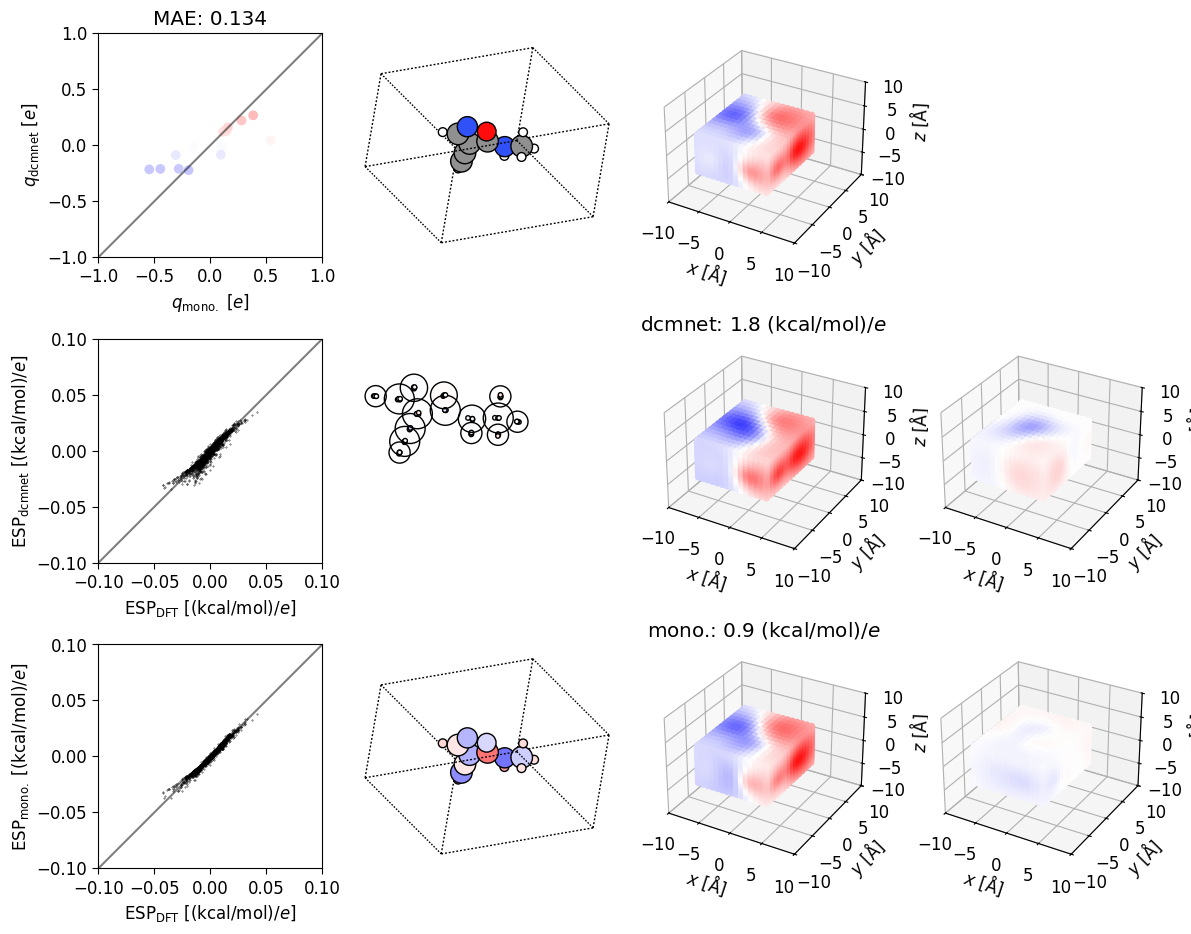

 25%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 1/4 [00:06<00:18,  6.24s/it]

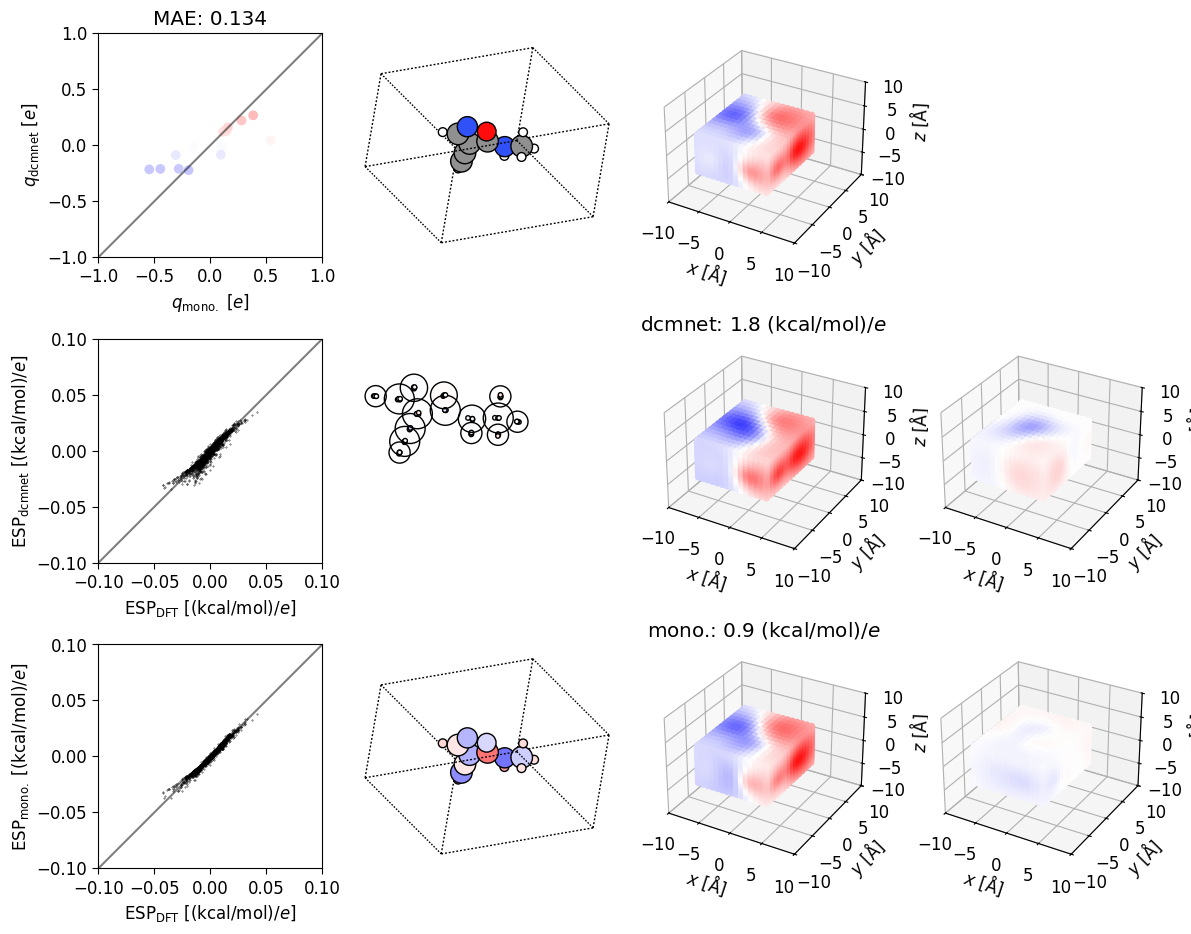

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 2/4 [00:12<00:12,  6.46s/it]

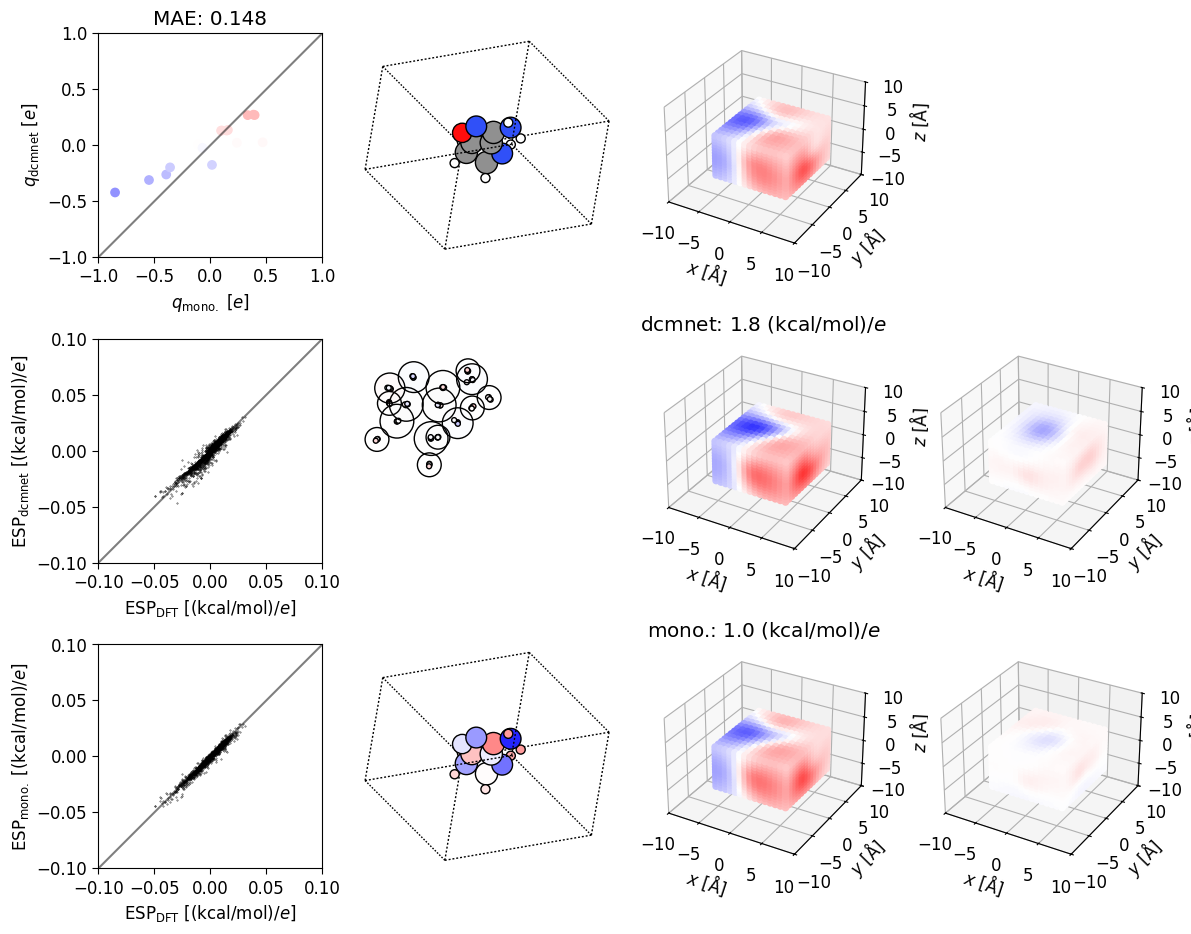

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3/4 [00:18<00:06,  6.29s/it]

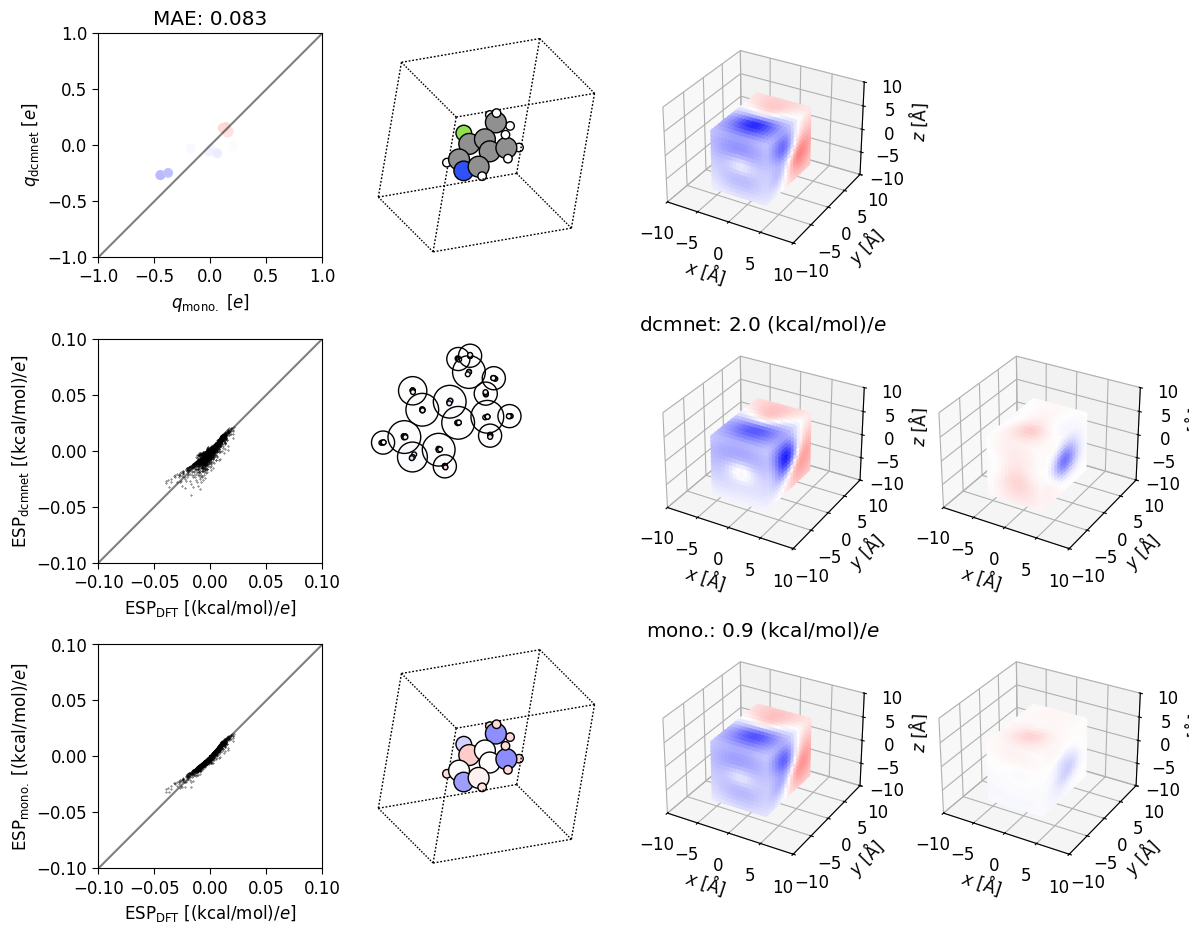

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.46s/it]


In [68]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(good[:4]):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=False,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

# m, l0 = np.array(esp_errors).T
# plt.hist(l0.flatten(), alpha=0.4)
# plt.hist(m.flatten(), alpha=0.4)
# plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
# plt.show()
# dl0, dm = np.array(dipole_errors).T
# plt.hist(dl0.flatten(), alpha=0.4)
# plt.hist(dm.flatten(), alpha=0.4)
# plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
# plt.show()

In [42]:
bad = list(df_[df_["difd"] > 0].sort_values("difd", ascending=False)["i"])
len(bad)
df_[df_["difd"] > 0].describe()

,i,m,l0,dm,dl0,dif,difd
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,3098.230769,1.555424,1.147273,0.159564,0.065424,0.408151,0.094140
std,1831.661220,0.362059,0.425584,0.093377,0.051391,0.331904,0.080510
min,253.000000,0.930214,0.589138,0.031893,0.000743,-0.043220,0.008335
25%,1311.750000,1.329536,0.913439,0.093321,0.023337,0.188559,0.022936
50%,3291.500000,1.463024,1.010482,0.127485,0.064956,0.312999,0.084382
75%,4305.750000,1.711807,1.286156,0.259010,0.087680,0.511053,0.142457
max,6180.000000,2.275575,2.318795,0.326307,0.217040,1.360412,0.303152


  0%|                                                                                                                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

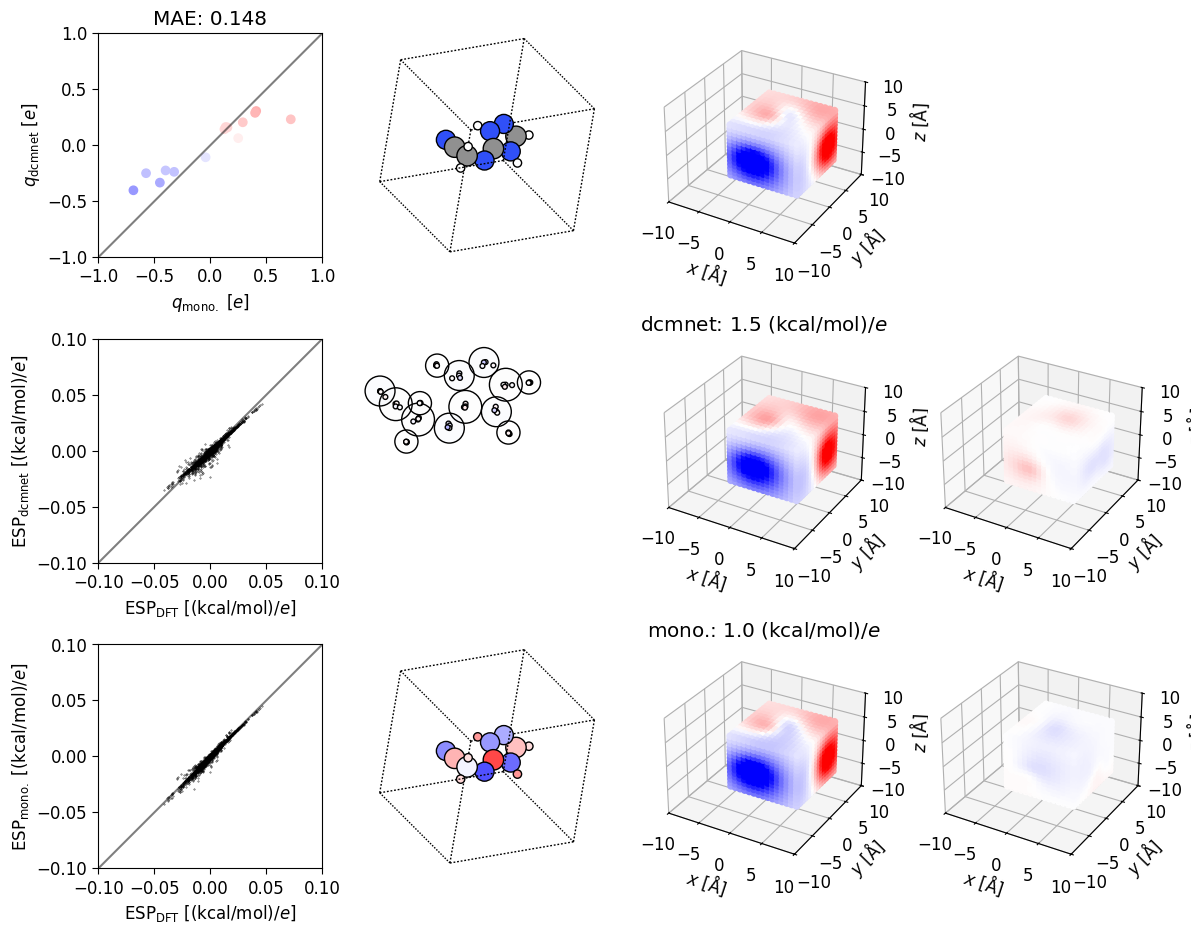

 25%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 1/4 [00:06<00:19,  6.44s/it]

4.085517 [4.39851054] [0.31299361]


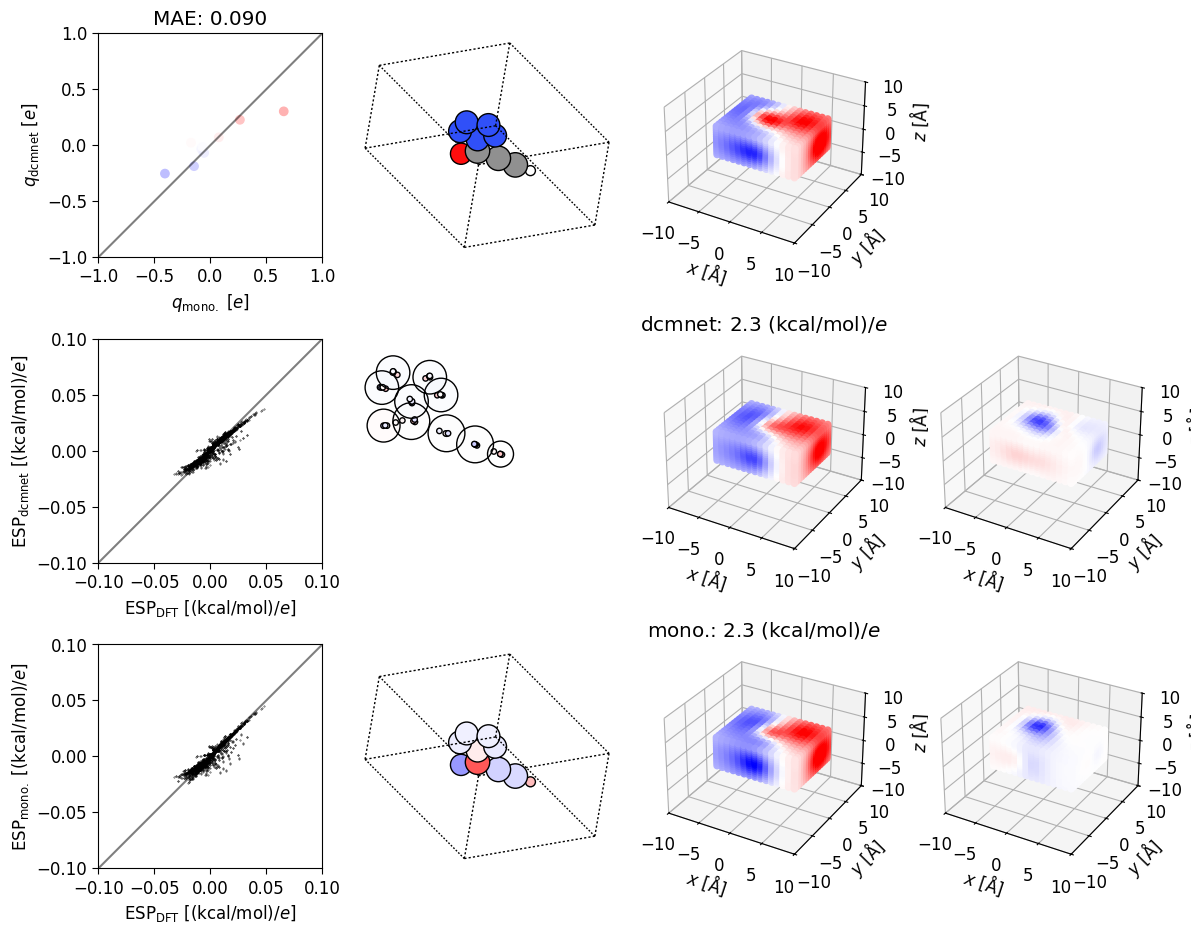

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 2/4 [00:12<00:12,  6.27s/it]

4.094768 [4.42107514] [0.3263071]


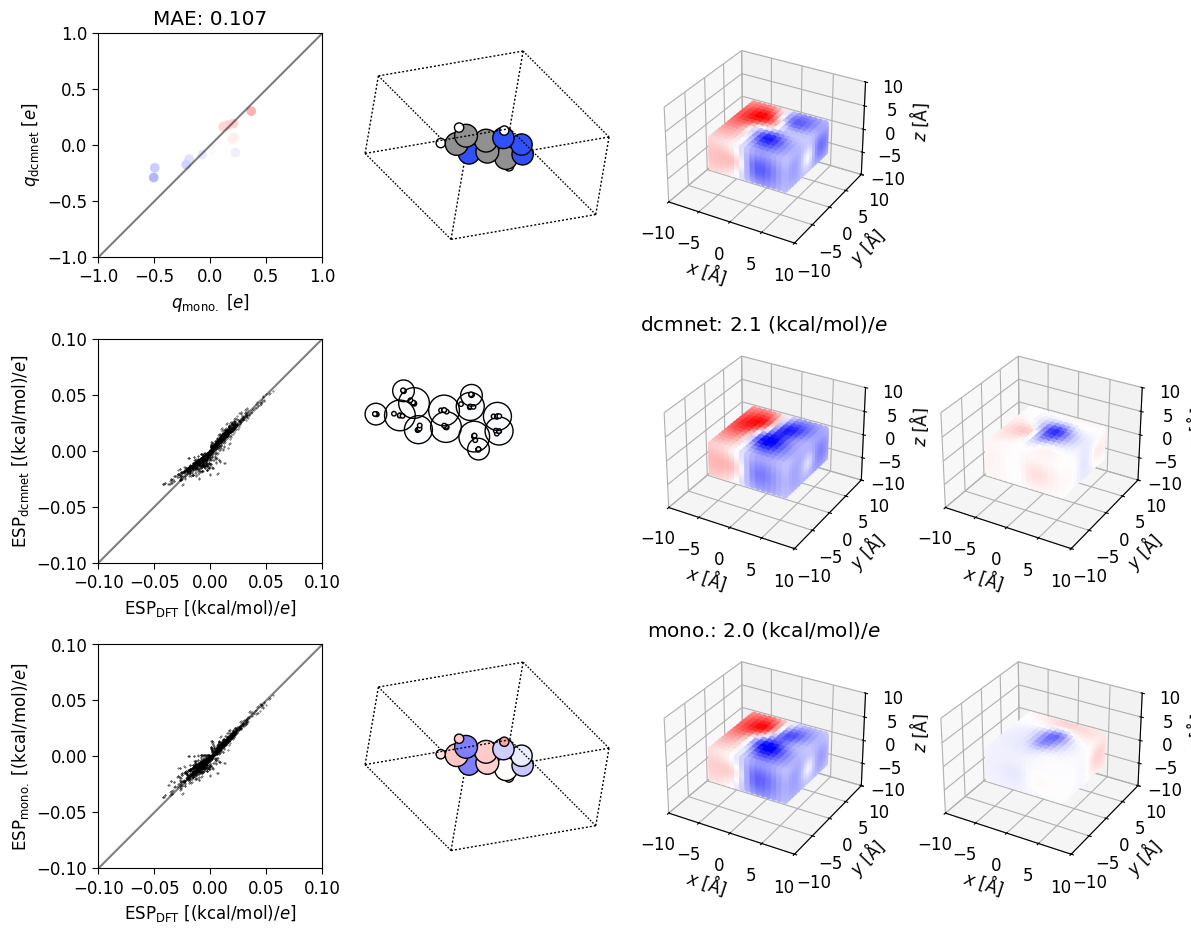

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3/4 [00:18<00:06,  6.15s/it]

3.9119675 [3.63937017] [0.27259734]


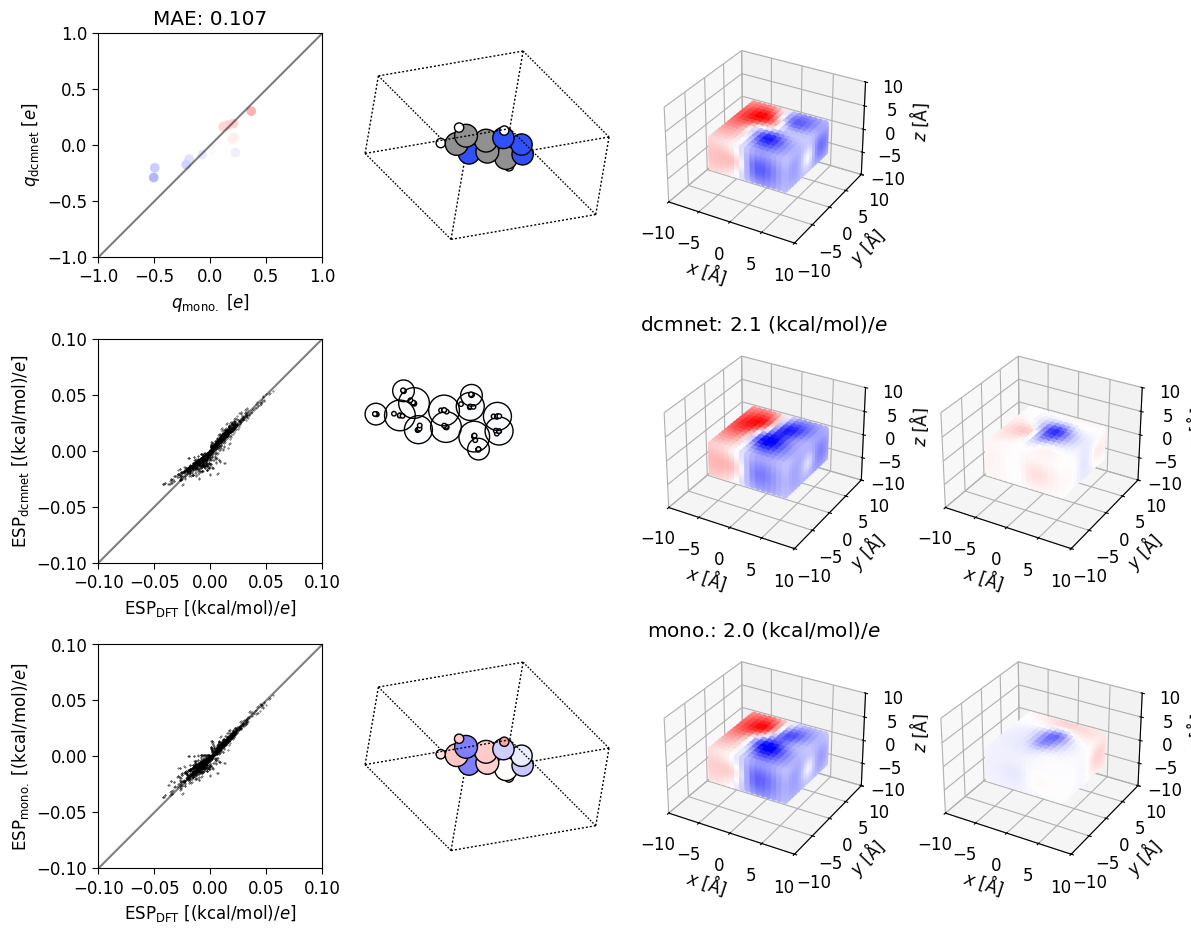

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.23s/it]

3.9119675 [3.63937017] [0.27259734]


In [43]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(bad[:4]):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=False,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    print(pred_D, D_test, abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

# m, l0 = np.array(esp_errors).T
# plt.hist(l0.flatten(), alpha=0.4)
# plt.hist(m.flatten(), alpha=0.4)
# plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
# plt.show()
# dl0, dm = np.array(dipole_errors).T
# plt.hist(dl0.flatten(), alpha=0.4)
# plt.hist(dm.flatten(), alpha=0.4)
# plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
# plt.show()

In [304]:
import ase
old_params = params

In [305]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")

# p = ddir / "test2/20240926-195014dcm-2-w-10000.0-re-False-ptTrue/best_10000.0_params.pkl"
# p = ddir / "test2/20240926-201945dcm-2-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"
# p = ddir / "test2/20240926-201913dcm-3-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"
# p = ddir / "test2/20240926-201827dcm-4-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"

print(p)
model, params, _ = create_model_and_params(p, debug=True)
model

/pchem-data/meuwly/boittier/home/jaxeq/all_runs/test4/20241002-180931dcm-3-w-10000.0-re-True-ptTrue/best_10000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 3.0, 'include_pseudotensors': False, 'debug': True}


MessagePassingModelDEBUG(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 3
    include_pseudotensors = True
)

In [306]:
# batch

In [307]:
_m, _d = model.apply(params,
        atomic_numbers=batch["Z"],
        positions=batch["R"],
        dst_idx=batch["dst_idx"],
        src_idx=batch["src_idx"],
        batch_segments=batch["batch_segments"],
        batch_size=1,)

basis (Array(3540, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, we

In [308]:
np.linalg.norm(_d,axis=1)

array([[0.7358765 , 0.34732628, 0.12671013],
       [0.14720917, 0.16912892, 0.2169313 ],
       [0.53160477, 0.46091503, 0.04518038],
       [0.1335833 , 0.4499205 , 0.03976565],
       [0.5868    , 0.18741836, 0.08137356],
       [0.24762842, 0.33760136, 0.0708481 ],
       [0.3123494 , 0.2919045 , 0.02787892],
       [0.28033724, 0.87105596, 0.02332366],
       [0.28429598, 0.03987217, 0.12731811],
       [0.21258208, 0.12271738, 0.22209354],
       [0.23485722, 0.12532413, 0.22435988],
       [0.09019406, 0.45343223, 0.05713031],
       [0.09563288, 0.45580366, 0.05810704],
       [0.3246493 , 0.03708269, 0.06658595],
       [0.24866341, 0.31090048, 0.07462561],
       [0.12050959, 0.16656856, 0.03493291],
       [0.12050959, 0.16656856, 0.03493291],
       [0.12050959, 0.16656856, 0.03493291],
       [0.12050959, 0.16656856, 0.03493291],
       [0.12050959, 0.16656856, 0.03493291],
       [0.12050959, 0.16656856, 0.03493291],
       [0.12050959, 0.16656856, 0.03493291],
       [0.

In [309]:
params["params"].keys()

dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3', 'Dense_4', 'Embed_0', 'MessagePass_0', 'MessagePass_1', 'TensorDense_0', 'element_bias'])

In [310]:
EMBED = params["params"]["Embed_0"]["embedding"].squeeze(axis=1).squeeze(axis=1)
EMBED.shape

(18, 16)

Text(0.5, 0, 'Feature')

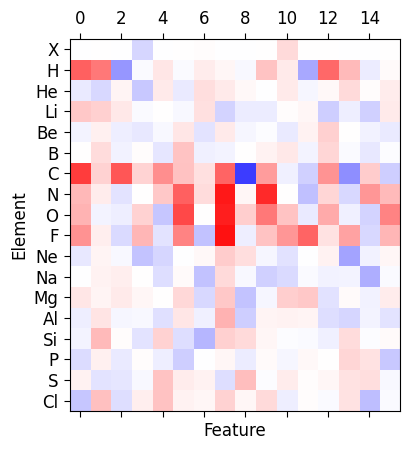

In [311]:
plt.matshow(EMBED, vmin=-2, vmax=2)
ax = plt.gca()
_ = ax.set_yticks(range(EMBED.shape[0]), ase.data.chemical_symbols[:EMBED.shape[0]])
ax.set_ylabel("Element")
ax.set_xlabel("Feature")

(3, 3, 16)


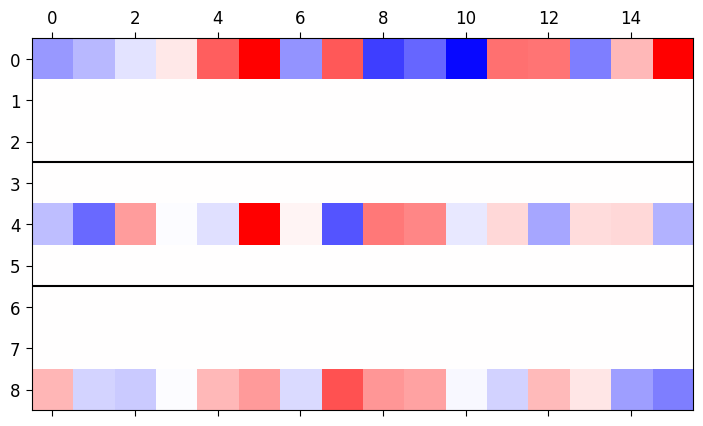

In [312]:
X = params\
    ["params"]["MessagePass_0"]["tensor"]["kernel"].squeeze()
print(X.shape)
X=X.reshape(9,16)
plt.matshow(X, vmin=-2, vmax=2)
plt.axhline(2.5, color="k")
plt.axhline(5.5, color="k")

(3, 3, 3, 16)


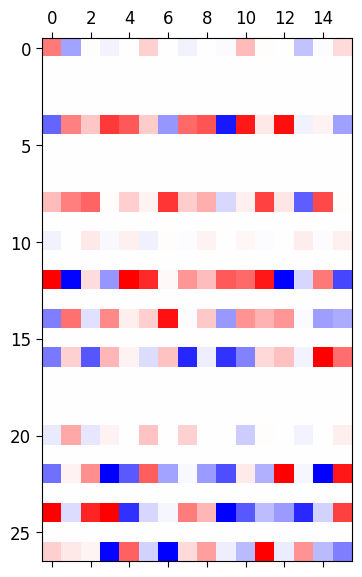

In [313]:
X = params\
    ["params"]["MessagePass_1"]["tensor"]["kernel"].squeeze()
print(X.shape)
X=X.reshape(27,16)
plt.matshow(X, vmin=-2, vmax=2)

In [314]:
params["params"]["element_bias"].shape

(18,)

In [315]:
# params["params"]["Dense_1"]

In [316]:
DENSE0 = params["params"]["Dense_0"]
DENSE0.keys()

dict_keys(['0+', '1-', '2+'])

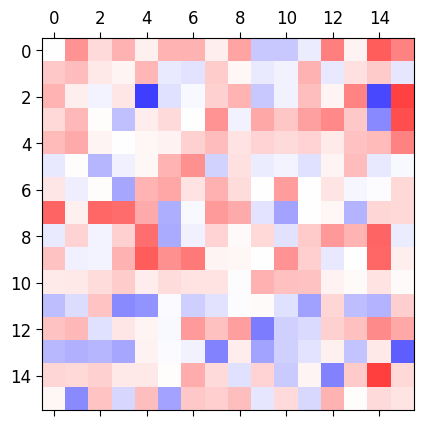

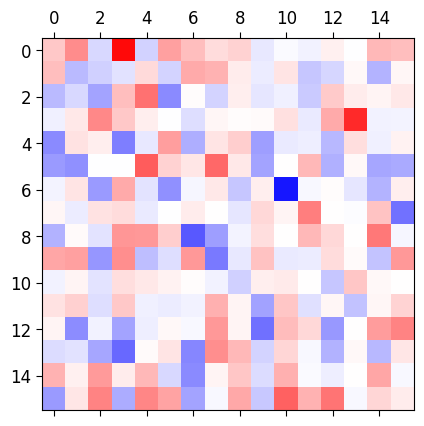

In [317]:
plt.matshow(DENSE0["0+"]["kernel"], vmin=-2, vmax=2)
plt.matshow(DENSE0["1-"]["kernel"], vmin=-2, vmax=2)
# plt.colorbar()

(3, 6, 16)


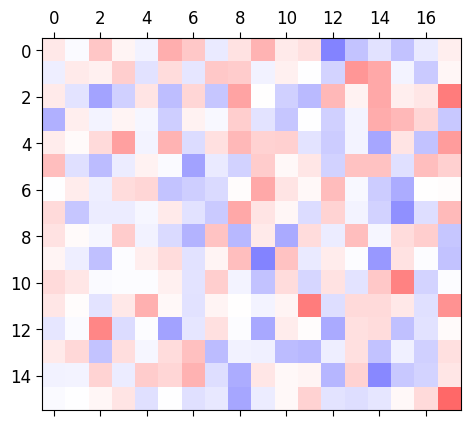

In [324]:
types = ["0+", "1-", "2+"]
X = np.array([params["params"]["TensorDense_0"]["dense"][_]["kernel"].T for _ in types])
print(X.shape)
X = X.reshape(X.shape[0]*X.shape[1],16).T
plt.matshow(X, vmin=-2, vmax=2)
# plt.axvline(3.5, color="k")
# plt.axvline(7.5, color="k")
# plt.axvline(10.5, color="k")

In [325]:
# params["params"]["TensorDense_0"]

In [326]:
X = params["params"]["TensorDense_0"]["tensor"]["kernel"].squeeze() #.reshape(9,4)
# X.shape, X

In [328]:
X = params["params"]["TensorDense_0"]["tensor"]["kernel"].squeeze()
X = X.reshape(9,X.shape[-1]*2)
X.shape

(9, 6)

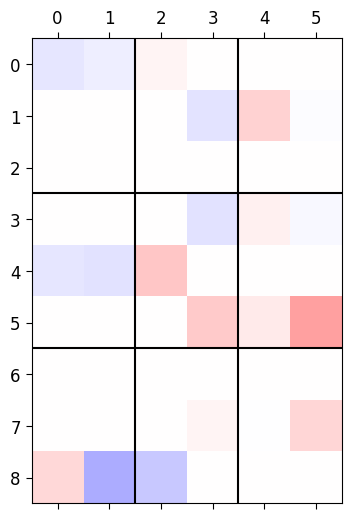

In [331]:
plt.matshow(X, vmin=-2, vmax=2)
plt.axhline(2.5, c="k")
plt.axhline(5.5, c="k")
plt.axvline(1.5, c="k")
plt.axvline(3.5, c="k")

In [38]:
X.shape

(9, 4)

In [39]:
params["params"]["TensorDense_0"]["tensor"]["kernel"].squeeze().shape

(3, 3, 2, 2)